In [1]:
# Load relevant modules

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


# Problem 1:

In [2]:

def fun(x, choice):
    ''' choice is either 'exp(x)', or 'exp(0.01x)' 
    -> returns (function, true derivative)'''
    if choice == 'exp(x)':
        return (np.exp(x), np.exp(x))
    else:
        return (np.exp(0.01*x), 0.01 * np.exp(0.01*x))

choice = 'exp(x)'  # Choose which function to use
precision = 'double'  # Determine whether to compute epsilon with single or double precision
x = 42  # Pick a random x value

if precision == 'single':
    epsilon = 1e-7
else:
    epsilon = 1e-16

# Compute delta according to the results from the PDF
if choice == 'exp(x)':
    delta = epsilon**(1/5)
else:
    delta = 100 * epsilon**(1/5)

# First define the point x + delta, call it x2
x2 = x + delta

# Use the trick to have delta in 'countable' units
delta = x2 - x

# Evaluate the derivative from x +- delta
deriv_1 = (fun(x2, choice)[0] - fun(x - delta, choice)[0])/(2*delta)

# Now evaluate the derivative from x +- 2delta
deriv_2 = (fun(x + 2*delta, choice)[0] - fun(x - 2*delta, choice)[0])/(4*delta)

# Combine them using the linear combination presented in the PDF
deriv = 4/3 * deriv_1 - 1/3 * deriv_2

# Compute the true derivative
true_deriv = fun(x, choice)[1]

# Print out results
print("Problem 1 (b)",
      f"\nFor {choice} and x = {x}"
      f"\nFor {precision} precision",
      "\nNumerical derivative:",
      deriv,
      "\nTrue derivative:",
      true_deriv,
      "\nFractional error:",
      np.abs(deriv/true_deriv-1))

Problem 1 (b) 
For exp(x) and x = 42
For double precision 
Numerical derivative: 1.739274941520394e+18 
True derivative: 1.739274941520501e+18 
Fractional error: 6.150635556423367e-14


# Problem 2:

In [3]:

def ndiff(fun, x, full=False):
    
    epsilon = 1e-16  # Just use double precision
    dx = 1  # Pick a random size for the initial estimate of dx
    
    for i in range(3):  # Repeat three times to get the optimal dx value
   
        # Compute f''' according to Eq. 5 in the PDF
        f3 = (-fun(x+dx) - fun(x-dx) + 2*fun(x))/(dx**3)

        # Compute the optimal dx
        dx = np.abs((epsilon*fun(x)/f3))**(1/3)
        
    # Now compute the derivative
    deriv = (fun(x+dx) - fun(x-dx))/(2*dx)
    
    # Estimate the error according to Eq. 6 in the PDF
    err = (epsilon*fun(x))/dx + ((dx**2) * f3)
    
    if full:
        return deriv,dx,np.abs(err/deriv)  # Return the fractional error --> it is more visual than just the error
    return deriv

# Example:
print(ndiff(np.exp, 42, full=True))

(1.7392748827369134e+18, 1.940262771281828e-08, 1.425624694099209e-23)


# Problem 3:

(2000 interpolated points) Mean error: 12.338788344474944 +- 18.79693260798189


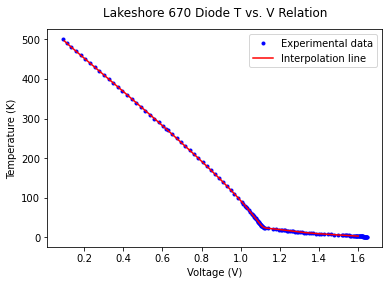

Voltage points: [0.1 0.2 0.3 0.4]
Interpolated temperature points: [495.66893911 452.82275501 410.91132944 368.51045156]
Error on each interpolated point: [1.12745052 0.28253029 0.33903881 0.40873556]
Fractional error on each interpolated point: [0.0022746  0.00062393 0.00082509 0.00110916]
Mean fractional error: 0.0012081952880152566 +- 0.0006393688910661493


In [4]:

# --------------- First create the bootstrapping algorithm --------------------------------------------

def bootstrap(V,data,n=9999):
    '''Given some voltage points and the output of np.loadtxt("lakeshore.txt")
    bootstrap resample from data n times in order to estimate the error on the interpolation of V'''
    
    # Recover voltage and temperature from text file
    volt = data[:,1]
    temp = data[:,0]
    
    # Create an array of indices
    ind = np.linspace(0, len(volt)-1, len(volt))
    
    # Iterate
    bootstrap_inter = []  # Huge list of all bootstrapped interpolation values
    
    for i in range(n):
        
        # Resample the indices
        r_ind = np.random.choice(ind, size=len(ind))
        
        # Pick out the corresponding voltage and temperature; remove duplicates
        r_volt = np.unique(volt[[int(i) for i in r_ind]])
        r_temp = np.unique(temp[[int(i) for i in r_ind]])
        
        # Put them in order of increasing voltage
        r_volt,r_temp = (np.asarray(t) for t in zip(*sorted(zip(r_volt, r_temp))))
        
        # Interpolate V from the resampled data
        r_spln = interpolate.splrep(r_volt, r_temp)
        r_inter = interpolate.splev(V, r_spln)
        
        # Add interpolated points to the list of all interpolated points
        bootstrap_inter.append(r_inter)
        
    bootstrap_inter=np.asarray(bootstrap_inter)
    
    # The error is the standard deviation on the bootstrapped interpolation values
    return np.std(bootstrap_inter, axis=0)


# ------------------ Lakeshore function -------------------------------------------------


def lakeshore(V,data):
    
    # Recover voltage and temperature from text file
    volt = data[:,1]
    temp = data[:,0]
    
    # Sort them by increasing voltage (instead of temperature)
    volt,temp = (np.asarray(t) for t in zip(*sorted(zip(volt, temp))))
    
    # Get the cubic splines, then interpolate
    spln = interpolate.splrep(volt, temp)
    temp_inter = interpolate.splev(V, spln, ext=2)
    
    # Get the error using bootstrap sampling
    error = bootstrap(V,data)
    
    return temp_inter, error


# ------------------ Test it out -------------------------------------


data = np.loadtxt("lakeshore.txt")

volt = data[:,1]
temp = data[:,0]

volt_test = np.linspace(0.1,1.6,2000)
temp_test = lakeshore(volt_test, data)

print("(2000 interpolated points) Mean error:", np.mean(temp_test[1]), '+-', np.std(temp_test[1]))

plt.plot(volt, temp, '.', color='blue', label="Experimental data")
plt.plot(volt_test, temp_test[0], color='red', label="Interpolation line")
plt.xlabel("Voltage (V)")
plt.ylabel("Temperature (K)")
plt.title("Lakeshore 670 Diode T vs. V Relation",y=1.03)
plt.legend()

#plt.savefig("lakeshore.png",dpi=500,bbox_inches='tight')

plt.show()


# ------------------------ Test it out for a smaller number of data points

volt_test2 = np.array([0.1,0.2,0.3,0.4])
temp_test2 = lakeshore(volt_test2, data)

print("Voltage points:",volt_test2)
print("Interpolated temperature points:",temp_test2[0])
print("Error on each interpolated point:", temp_test2[1])
print("Fractional error on each interpolated point:", temp_test2[1]/temp_test2[0])
print("Mean fractional error:", np.mean(temp_test2[1]/temp_test2[0]), '+-', np.std(temp_test2[1]/temp_test2[0]))

# Problem 4

Average error from polynomial interpolation: 0.0009317327665490618
Average error from cubic spline interpolation: 0.00029403740732233854
Average error from rational function interpolation: 2.6008721206253665e-16

p term in rational function: [ 1.00000000e+00  1.33226763e-15 -3.33333333e-01 -1.77635684e-15]
q term in rational function: [ 1.77635684e-15  6.66666667e-01 -8.88178420e-16 -3.33333333e-01]


/home/jade_ducharme/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


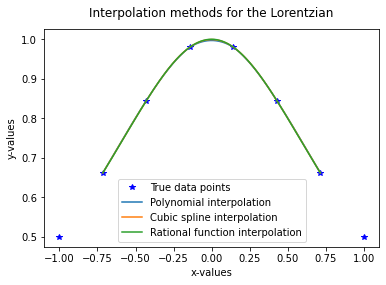

In [7]:

def lorentz(x):
    ''' Return the Lorentzian '''
    return 1/(1+x**2)

n=4
m=5
num = n+m-1
xmin = -1
xmax = 1
x = np.linspace(xmin, xmax, num)  # 'True' x values
dx = np.median(np.diff(x))
y = lorentz(x)  # 'True' y values

xx = np.linspace(x[1], x[-2], 1001)  # x values I wish to interpolate
yy_true = lorentz(xx)  # True y values for the x values i wish to interpolate


# -------------- 1) Polynomial interpolation ---------------------------------------------


yy_poly = 0 * xx  # Get an array of zeros of the same size

for i, myx in enumerate(xx):
    j = int((myx-xmin)/dx)
    pp = np.polyfit(x[j-1:j+3], y[j-1:j+3], 3)
    yy_poly[i] = np.polyval(pp,myx)
    
err_poly = np.mean(np.abs(yy_true-yy_poly))
print("Average error from polynomial interpolation:",err_poly)
    
    
# -------------- 2) Cubic spline interpolation ----------------------------------------------


spln = interpolate.splrep(x,y)
yy_spline = interpolate.splev(xx,spln,ext=2)

err_spline = np.mean(np.abs(yy_true-yy_spline))
print("Average error from cubic spline interpolation:",err_spline)


# -------------- 3) Rational function interpolation -------------------------------


def rat_eval(p,q,x):
    ''' From PHYS 512 Lecture 2'''
    top=0
    for i in range(len(p)):  # Evaluate the top polynomial
        top=top+p[i]*x**i
    bot=1
    for i in range(len(q)):  # Evaluate the bottom polynomial
        bot=bot+q[i]*x**(i+1) 
    return top/bot  # Return the rational function

def rat_fit(x,y,n,m):
    ''' From PHYS 512 Lecture 2 '''
    assert(len(x)==n+m-1)
    assert(len(y)==len(x))
    mat=np.zeros([n+m-1,n+m-1])
    for i in range(n):
        mat[:,i]=x**i
    for i in range(1,m):
        mat[:,i-1+n]=-y*x**i
    pars=np.dot(np.linalg.pinv(mat),y)
    p=pars[:n]
    q=pars[n:]
    return p,q

p,q = rat_fit(x,y,n,m)
yy_rat = rat_eval(p,q,xx)

err_rat = np.mean(np.abs(yy_true-yy_rat))
print("Average error from rational function interpolation:",err_rat)
print("\np term in rational function:",p)
print("q term in rational function:",q)


# --------------- Plot everything ------------------------------------------------


plt.plot(x, y, '*', color='blue', label="True data points")
plt.plot(xx, yy_poly, label="Polynomial interpolation")
plt.plot(xx, yy_spline, label="Cubic spline interpolation")
plt.plot(xx, yy_rat, label="Rational function interpolation")

plt.xlabel("x-values")
plt.ylabel("y-values")
plt.title("Interpolation methods for the Lorentzian", y=1.03)

plt.legend()

#plt.savefig("lorentz_rat.png",dpi=500,bbox_inches='tight')
plt.show()
